<a href="https://colab.research.google.com/github/G750cloud/20MA573/blob/master/HW4(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volatility calibration to BSM

## Abstract

- Goal
    - Calibrate BSM model for makert price of options


## Problem

All of pricing models require a set of model parameters in order to fully define the dynamics of each model. The process of adjusting model parameters such that the model prices are compatible with market prices is called **Calibration**. 

Input:

- market prices of several options with different strikes and maturities
- spot price
- interest rates

Output:

- Find volatility of BSM model

## Anal


Suppose
- Model prameter $\theta = (\theta_1, ... \theta_m)$ is a vector
- Prices of $n$ instruments are aviable in the market with its market price of $i$th instrument quoted by $C_i$. 
Let's denote $C = (C_1, ..., C_n)$ as a market price vector.
- In theory, $C_i^\theta$ is the model price of the $i$th instrument, and they are denoted as a vector $C^\theta = (C_1^\theta, ...,  C^\theta_n)$. 

Given a distance function $H: \mathbb R^n \times \mathbb R^n \mapsto \mathbb R^+$, calibration is to find the parameter $\theta^*$  which minimize the objective function $H(C^\theta, C)$, i.e.
$$ \theta^* = \arg\min_\theta H(C^\theta, C).$$

Commonly used distance functions for $H$ are 
- $H(x, y) = (\sum_{i=1}^n w_i |x_i - y_i|^p)^{1/p}.$
- $H(x, y) = (\sum_{i=1}^n w_i | \frac{x_i - y_i}{y_i}|^p)^{1/p}.$ If $p = 2$, $w_i =1$, then $H^2$ is called as SSRE (sum of squred relative errors)
- $H(x, y) = (\sum_{i=1}^n w_i |\ln x - \ln y|^p)^{1/p}.$

In this below, we are goint to use, the first case of $H$ with $p = 2$ and $w_i = 1$ for all i's.

# Hw Tasks

## Task-1

- Upload data from [here](https://github.com/songqsh/20s_ma573/blob/master/src/20optiondata2.dat) to your cloud platform
- Calibration/Performance:
  - Filter out 2-mon options and calibrate volatility using the distance function
$$H(x, y) = (\sum_{i=1}^n w_i |x_i - y_i|^2)^{1/2}.$$
  - Calibrated price for option means the computed option price using calibrated volatility and other parameters given by the market. Compare the market price and calibrated price using a plot of two curves: strike vs market (calibrated) price
- Do the same thing for the filter from 5-mon options.
- Which calibrated volatility is bigger, 2-mon or 5-mon?


Cloning into '20s_MA573'...
remote: Enumerating objects: 213, done.
remote: Total 213 (delta 0), reused 0 (delta 0), pack-reused 213
Receiving objects: 100% (213/213), 670.50 KiB | 11.17 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/20s_MA573/src/20s_MA573/src/20s_MA573/src/20s_MA573/src/20s_MA573/src/20s_MA573/src/20s_MA573/src/20s_MA573/src
20optiondata2.dat
>>>>>>otype, maturity, strike, option_price
[[  1.           0.16666667  97.           5.32705461]
 [  1.           0.16666667  99.           3.86224255]
 [  1.           0.16666667 101.           2.7204371 ]
 [  1.           0.16666667 103.           2.1202793 ]
 [  1.           0.41666667  97.           7.23756307]
 [  1.           0.41666667  99.           5.95053461]
 [  1.           0.41666667 101.           5.2640122 ]
 [  1.           0.41666667 103.           4.97493422]]
evaluated_volatility is [0.18111844]
evaluated vol option price: [array([5.18456528]), array([3.92289819]), array([2.87133546]), array([

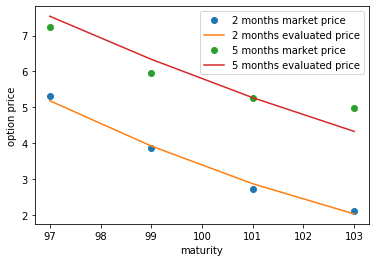

In [8]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.optimize as so
from scipy.optimize import leastsq

#P1#
!git clone https://github.com/songqsh/20s_MA573.git
%cd 20s_MA573/src/
%ls 20optiondata2.dat
np_option_data1 = np.loadtxt('20optiondata2.dat', comments='#', delimiter=',')
print('>>>>>>otype, maturity, strike, option_price')
print(np_option_data1)

#P2#
class VanillaOption:
    def __init__(
        self,
        otype = 1, # 1: 'call'
                  # -1: 'put'
        strike = 110.,
        maturity = 1.,
        market_price = 10.):
      self.otype = otype
      self.strike = strike
      self.maturity = maturity
      self.market_price = market_price #this will be used for calibration
    
    def explain_yourself(self):
      if self.otype==1:
        print('I am call')
      elif self.otype==-1:
        print('I am put')

        
    def payoff(self, s): #s: excercise price
      otype = self.otype
      k = self.strike
      maturity = self.maturity
      return max([0, (s - k)*otype])



class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio



    def bsm_price(self, vanilla_option):
        s0 = self.init_state
        sigma = self.vol_ratio
        r = self.drift_ratio
        
        otype = vanilla_option.otype
        k = vanilla_option.strike
        maturity = vanilla_option.maturity
        
        d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) 
              * maturity) / (sigma * np.sqrt(maturity))
        d2 = d1 - sigma * np.sqrt(maturity)
        
        return (otype * s0 * ss.norm.cdf(otype * d1) #line break needs parenthesis
                - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2))

gbm1 = Gbm(
    init_state = 100, #market data
    drift_ratio = .05, #market data
    vol_ratio = .1 #initial guess
)

num_row = np_option_data1.shape[0]
option_list1 = []

for i in range(num_row):
  option1 = VanillaOption(
      otype = np_option_data1[i,0],
      strike = np_option_data1[i,2],
      maturity = np_option_data1[i,1],
      market_price = np_option_data1[i,3]
  )
      
  option_list1.append(option1) 

def H_function(vol, gbm, option_list):
  gbm.vol_ratio = vol
  H1 = 0
  for i in np.arange(len(option_list)):
    H1 = H1 + ((option_list[i]).market_price - gbm.bsm_price(option_list[i]))**2    
  return H1

def bsm_calibration(gbm, option_list):
  init_vol = .1 #initial guess
  return(so.leastsq(H_function, init_vol, args = (gbm, option_list))[0])

filter1 = list(filter(lambda x: x.maturity == 2/12, option_list1))
calibrated_volatility1 = bsm_calibration(gbm1, filter1)
print('evaluated_volatility is ' + str(calibrated_volatility1))

gbm1.vol_ratio = calibrated_volatility1
filter1_calibrated_price = [gbm1.bsm_price(filter1[i]) for i in range(len(filter1))]
print('evaluated vol option price:', filter1_calibrated_price)

filter1_calibrated_price
x_co = [filter1[i].strike for i in range(len(filter1))]
y_co = [filter1[i].market_price for i in range(len(filter1))]
plt.plot(x_co, y_co, 'o', label='2 months market price')

y_co = filter1_calibrated_price
plt.plot(x_co, y_co, label = '2 months evaluated price')

plt.ylabel('option price')
plt.xlabel('2-mon maturity')
plt.legend();

#P3#
filter2 = list(filter(lambda x: x.maturity == 5/12, option_list1))
calibrated_volatility2 = bsm_calibration(gbm1, filter2)
print('evaluated_volatility is ' + str(calibrated_volatility1))

gbm1.vol_ratio = calibrated_volatility2
filter2_calibrated_price = [gbm1.bsm_price(filter2[i]) for i in range(len(filter1))]
print('evaluated vol option price:', filter2_calibrated_price)

filter2_calibrated_price
x_co = [filter2[i].strike for i in range(len(filter2))]
y_co = [filter2[i].market_price for i in range(len(filter2))]
plt.plot(x_co, y_co, 'o', label='5 months market price')

y_co = filter2_calibrated_price
plt.plot(x_co, y_co, label = '5 months evaluated price')

plt.ylabel('option price')
plt.xlabel('maturity')
plt.legend();



## Task-2 (optional)
Please discuss the validity of the following statements:
- Given an underlying asset, options with shorter maturity can be better fitted than a longer maturity.
- Suppose Assest1(ex. AAPL) is more liquid than Asset2 (ex. TAL). Then Asset1 can be fit better than Asset2.